In [251]:
# All Imports
from collections import Counter
from operator import itemgetter
import ConfigParser
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
import io
import os
import re
import nltk
import string
import shutil
import hashlib
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#nltk.download()
from tabulate import tabulate
from nltk.corpus import sentiwordnet
from nltk.corpus import SentiWordNetCorpusReader, SentiSynset
import pylab as plt
import numpy as np
import scipy.stats as stats
import pylab as pl
%matplotlib inline
swn_root = './'
swn_filename = 'SentiWordNet_3.0.0_20130122.txt'
swn = SentiWordNetCorpusReader(swn_root,swn_filename,encoding='utf-8')

In [2]:
# Converts a file to list of strings where each item is one line of the file.
def file2string(filename):
    result = []
    result = io.open(filename, encoding='utf8').readlines()
    for val in range(0,len(result)):
        result[val]=re.sub("\n","",result[val])        
    return result

In [70]:
#Create a dictionary with product id as key and item title and manufacturer tuple as value taking a file as input
def productsDictionary(productsfile):
    productlst = file2string(productsfile)
    result = {}
    for product in productlst:
        temp = product.split("\t")
        result[temp[0]]=(temp[1],temp[2])
    return result

product_dictionary = productsDictionary("items.txt")
print "Created product dictionary with",len(product_dictionary.keys()),"products"

Created product dictionary with 42 products


In [71]:
def calculateSynsetScore(review):
    tokens = nltk.word_tokenize(review)
    score = 0
    for t in tokens:
        try:
            synset = swn.senti_synsets(t)[0]
            #print t,"\t",synset
            score = score + synset.pos_score() - synset.neg_score()
        except(IndexError):
            #print "Index error at:", t
            pass
    return score

In [88]:
# preprocess the review data


# URLs
regURL = re.compile(r"http\S+")

# Spliting by word boundaries
regWordbound = re.compile(r"\W+")

# Replace Repeating words like gooooooooood 

regRepeat = re.compile(r"(.)\1{1,}", re.IGNORECASE);

def replace_repeat(match):
    return match.group(1)+match.group(1)

# Emoticons
#replacing emoticons, you can specify any name

emoticons = [('', [':-)', ':)', '(:', '(-:', ':-D', ':D', 'X-D', 'XD', 'xD', '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':(('] )]


punct_list = []

for i in string.punctuation:
    punct_list.append(i)
    
# Punctuations
punctuations = \
    [   #Classify all punctuation as same
        #you can control which punctuation to use by creating new punctuation list
        #i have stripped down all the punctuations, you can put something in that blank
        ('',punct_list ),\
    ]


    
#For emoticon regexes

def escape_paren(arr):
    return [review.replace(')', '[)}\]]').replace('(', '[({\[]') for review in arr]

def regUnion(arr):
    return '(' + '|'.join( arr ) + ')'

regEmoticons = [ (repl, re.compile(regUnion(escape_paren(regx))) ) \
                    for (repl, regx) in emoticons ]


#For punctuation replacement
def replace_punctuations(match):
    review = match.group(0)
    repl = []
    for (key, parr) in punctuations :
        for punc in parr :
            if punc in review:
                repl.append(key)
    if( len(repl)>0 ) :
        return ' ' + ' '.join(repl) + ' '
    else :
        return ' '


def preprocessUrls(review, subject='', query=[]):
    return re.sub( regURL, '', review )

def preprocessEmoticons(review, subject='', query=[]):
    for (repl, regx) in regEmoticons :
        review = re.sub(regx, ' '+repl+' ', review)
    return review

def preprocessPunctuations( review, subject='', query=[]):
    return re.sub( regWordbound , replace_punctuations, review )

def preprocessRepeatings(review, subject='', query=[]):
    return re.sub( regRepeat, replace_repeat, review )


def processAll(review, subject='', query=[]):

    if(len(query)>0):
        query_regex = "|".join([ re.escape(q) for q in query])
        review = re.sub( query_regex, '', review, flags=re.IGNORECASE )
    
    review = re.sub( regURL, '', review )
    

    for (repl, regx) in regEmoticons :
        review = re.sub(regx, ' '+repl+' ', review)


    review = review.replace('\'',' ')

    #replcae underscore with space
    review = review.replace('_',' ')
    

    review = re.sub( regWordbound , replace_punctuations, review )
    review = re.sub( regRepeat, replace_repeat, review )
    
    review = review.lower()
    
    list = review.split()
    for i,token in enumerate(list):
        if token == 'not':
            
            if i+1 < len(list):
                list[i+1] = 'not_' + list[i+1]
    
    return ' '.join(list)

In [89]:
#Replace the word which contains n't i.e wouldn't,shouldn't  
#   with  would not, should not and return the string.   

def replace_with_not(string):
    ns = ""
    suffix = "n't"
    word = "not"
    for stn in string.split():
        if stn.endswith(suffix):
            stn = stn[:-3]
            ns += stn + ' ' + word + ' '
        else:
            ns += stn + ' '
    return ns
    
replace_with_not("this wouldn't be replaced.")

'this would not be replaced. '

In [90]:
# Reads a file named (productID).txt and returns a list of all reviews present in that file for the given productID
def getAllReviews(productID):
    reviews = file2string("Reviews_Data/"+ productID+".txt") 
    result = []
    for review_line in reviews:
        #print review.split("->")[1],"\n"
        review = review_line.split("->")[1]
        r1 = processAll(review)
        review = replace_with_not(r1)
        score = calculateSynsetScore(review)
        result.append((review,score))
    return result

In [91]:
#Create a dictionary with product id as key and list of its reviews as value.

product_ids = product_dictionary.keys()
product_reviews = {}

for id in product_ids:
    reviews = getAllReviews(id)
    product_reviews[id]=reviews;
    print "Reading reviews for Product ID:",id,"\tNumber of total reviews:",len(reviews)

cnt = Counter()
for key in product_reviews.keys():
    #print "Product ID:",key,"\tNumber of reviews:",len(product_reviews[key])
    cnt[len(product_reviews[key])]+=1
print "\n",cnt

Reading reviews for Product ID: B011N5HFOE 	Number of total reviews: 8
Reading reviews for Product ID: B004KZJ0UM 	Number of total reviews: 316
Reading reviews for Product ID: B00ZOO1RFO 	Number of total reviews: 76
Reading reviews for Product ID: B00K6ZIL0K 	Number of total reviews: 22
Reading reviews for Product ID: B012BPRLO4 	Number of total reviews: 3
Reading reviews for Product ID: B00PGELA04 	Number of total reviews: 46
Reading reviews for Product ID: B00HRO37UC 	Number of total reviews: 53
Reading reviews for Product ID: B011KFQASE 	Number of total reviews: 100
Reading reviews for Product ID: B00PPTP9IO 	Number of total reviews: 92
Reading reviews for Product ID: B00Z1R85O0 	Number of total reviews: 15
Reading reviews for Product ID: B00VGNZ4PG 	Number of total reviews: 50
Reading reviews for Product ID: B015P3SH9W 	Number of total reviews: 59
Reading reviews for Product ID: B00VJ1P7TS 	Number of total reviews: 27
Reading reviews for Product ID: B01606KJ6C 	Number of total revi

In [77]:
#Calculates average sentiment of all reviews that a product received.
def productAverageScore(reviews_dict):
    result = []
    for pid in reviews_dict.keys():
        reviews_lst = reviews_dict[pid]
        sum = 0
        for review in reviews_lst:
            sum+=review[1]
        
        avg = sum/len(reviews_lst)
        result.append((pid,avg))
        result = sorted(result,key = itemgetter(1),reverse = True)
    
    return result
        
product_avg = productAverageScore(product_reviews)
#print product_avg[0][1]

cnt = 0
table = []
for val in range(len(product_avg)):
    cnt+=1
    table.append([product_avg[val][0],product_dictionary[product_avg[val][0]][0],product_avg[val][1]])
    
print tabulate(table,headers=["Product ID","Product Title","Sentiment Score"], tablefmt="fancy_grid", numalign="center")


╒══════════════╤════════════════════════════════════════════════════════════════════════════╤═══════════════════╕
│ Product ID   │ Product Title                                                              │  Sentiment Score  │
╞══════════════╪════════════════════════════════════════════════════════════════════════════╪═══════════════════╡
│ B00FF6J532   │ Microsoft Surface 2 (32 GB)                                                │      1.87577      │
├──────────────┼────────────────────────────────────────────────────────────────────────────┼───────────────────┤
│ B015P3SH9W   │ Dell Inspiron i7359-6790SLV 2-in-1 Touchscreen Laptop                      │      1.76483      │
├──────────────┼────────────────────────────────────────────────────────────────────────────┼───────────────────┤
│ B00IU745S8   │ G-Tab Iota Quad Core Android Tablet PC                                     │      1.43676      │
├──────────────┼────────────────────────────────────────────────────────────────────────

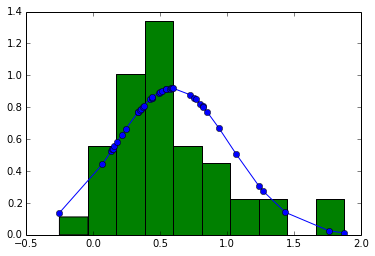

In [78]:
h = []
for i in range(len(product_avg)):
    h.append(product_avg[i][1])

h = sorted(h)
#print h   
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()

In [79]:
#Calculates average sentiment of all reviews that a product received.
def productFeatureScore(reviews_dict,feature):
    result = []
    for pid in reviews_dict.keys():
        reviews_lst = reviews_dict[pid]
        sum = 0.0
        cnt = 0.0
        for review in reviews_lst:
            reviewstr = review[0].lower()
            if re.findall(feature, reviewstr):
                sum+=review[1]
                cnt+=1
        if cnt != 0:
            avg = sum/cnt
            result.append((pid,avg))
        result = sorted(result,key = itemgetter(1),reverse = True)
    return result

In [80]:
#Searching for products with reviews related to touch
product_touch = productFeatureScore(product_reviews,"touch")

cnt = 0
table = []
for val in range(len(product_touch)):
    cnt+=1
    table.append([product_touch[val][0],product_dictionary[product_touch[val][0]][0],product_touch[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="fancy_grid", numalign="center")

╒═══════════════╤════════════════════════════════════════════════════════════════════════════╤═══════════════════╕
│ Item Number   │ Product Title                                                              │  Sentiment Score  │
╞═══════════════╪════════════════════════════════════════════════════════════════════════════╪═══════════════════╡
│ B00FF6J532    │ Microsoft Surface 2 (32 GB)                                                │      5.2301       │
├───────────────┼────────────────────────────────────────────────────────────────────────────┼───────────────────┤
│ B015P3SH9W    │ Dell Inspiron i7359-6790SLV 2-in-1 Touchscreen Laptop                      │      3.45652      │
├───────────────┼────────────────────────────────────────────────────────────────────────────┼───────────────────┤
│ B015JVB9C2    │ Dell Inspiron i3000-5099SLV Touchscreen Laptop                             │       3.375       │
├───────────────┼───────────────────────────────────────────────────────────────

In [55]:
#Searching for products with reviews related to processor
product_processor = productFeatureScore(product_reviews,"processor")

cnt = 0
table = []
for val in range(len(product_processor)):
    cnt+=1
    table.append([cnt,product_dictionary[product_processor[val][0]][0],product_processor[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="fancy_grid", numalign="center")

╒═══════════════╤════════════════════════════════════════════════════════════════════╤═══════════════════╕
│  Item Number  │ Product Title                                                      │  Sentiment Score  │
╞═══════════════╪════════════════════════════════════════════════════════════════════╪═══════════════════╡
│       1       │ Microsoft Surface 2 (32 GB)                                        │      8.97917      │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       2       │ Dell Latitude E6420 Premium 14.1-Inch Business Laptop              │       6.75        │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       3       │ Dell - Inspiron I3542-11001BK 15.6" Touch-Screen Laptop            │       5.125       │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       4       │ Dell Inspiron i7359

In [92]:
#Searching for products with reviews related to processor
product_storage = productFeatureScore(product_reviews,"storage")

cnt =0
table = []
for val in range(len(product_storage)):
    cnt+=1
    table.append([cnt,product_dictionary[product_storage[val][0]][0],product_storage[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="fancy_grid", numalign="center")
    

╒═══════════════╤═════════════════════════════════════════════════════════════╤═══════════════════╕
│  Item Number  │ Product Title                                               │  Sentiment Score  │
╞═══════════════╪═════════════════════════════════════════════════════════════╪═══════════════════╡
│       1       │ Microsoft Surface 2 (32 GB)                                 │      5.31731      │
├───────────────┼─────────────────────────────────────────────────────────────┼───────────────────┤
│       2       │ Dell Inspiron i3531-1200BK 16-Inch Laptop,Black             │      4.3125       │
├───────────────┼─────────────────────────────────────────────────────────────┼───────────────────┤
│       3       │ Dell Inspiron 15.6-Inch Touchscreen Laptop (i15RVT-6195BLK) │       4.25        │
├───────────────┼─────────────────────────────────────────────────────────────┼───────────────────┤
│       4       │ G-Tab Iota Quad Core Android Tablet PC                      │         3         │


In [65]:
#Create Graph for Every method. 

def Create_Graph(var):
    x = []
    y = []
    p = []
    for i in range(len(var)):
        p.append(i+1)
        #print p
        x.append(var[i][0])            
        y.append(var[i][1])
    plt.bar(p,y,align='center')
    #plt.figure(figsize=(1,1))
    plt.xticks(p)
    plt.xlabel('Products')
    plt.ylabel('Average Ratings')
    plt.show()
    table = []
    cnt = 0
    for i in x:
        cnt+=1
        table.append([cnt,i])
    print tabulate(table,headers=["Item Number","Product ID"], tablefmt="grid", numalign="center")


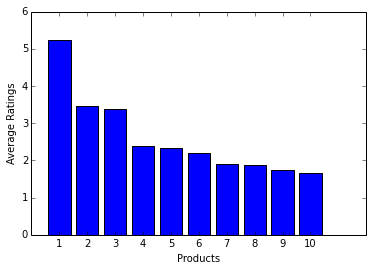

+---------------+--------------+
|  Item Number  | Product ID   |
+===============+==============+
|       1       | B00FF6J532   |
+---------------+--------------+
|       2       | B015P3SH9W   |
+---------------+--------------+
|       3       | B015JVB9C2   |
+---------------+--------------+
|       4       | B01606KJ6C   |
+---------------+--------------+
|       5       | B00ZS64K7K   |
+---------------+--------------+
|       6       | B00IU745S8   |
+---------------+--------------+
|       7       | B00NJNE6AA   |
+---------------+--------------+
|       8       | B011N5HFOE   |
+---------------+--------------+
|       9       | B00VGNZ4PG   |
+---------------+--------------+
|      10       | B011KFQASE   |
+---------------+--------------+


In [66]:
#lis = [('p',3),('q',3),('r',5),('s',1)]

Create_Graph(product_touch[:10])

In [ ]:
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    ###TODO
    ###
    
    
    vec = CountVectorizer(input = 'filename', tokenizer = tokenizer_fn,
                         min_df = min_df, max_df = max_df, binary = binary, ngram_range = ngram_range,dtype=int)    
    X=vec.fit_transform(filenames)
    return (X,vec)

    
matrix,vec = do_vectorize(all_train_files)
print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

In [115]:
pid = []
for i in range(len(product_avg)):
    pid.append(str(product_avg[i][0]))

In [116]:
pid[0]

'B00FF6J532'

In [117]:
result = []
for i in pid:
    reviews = file2string("Reviews_Data/"+ i +".txt")
    for review_line in reviews:
        review = review_line.split("->")[1]
        r1 = processAll(review)
        review = replace_with_not(r1)
        result.append(review)


In [120]:
i = 1
rslt = []
for review in result:
    score = calculateSynsetScore(review)
    rslt.append((review,score))
    f = open('Data/r'+ str(i) +'.txt','w+')
    f.write(review)
    f.close()
    i += 1

In [127]:
rslt[0]

(u'i discovered that windows rt is very limited and i doesn t suggest to buy rt version ',
 0.625)

In [134]:
# Here is the path to the data directory.
path = 'Data'
print('subdirectories are:' + str(os.listdir(path)))

subdirectories are:['test', 'train']


In [135]:
def get_files(path):
    list = []
    #get list of files in geiven directory
    for a in sorted(os.listdir(path)):
        #append all files path to list
        list.append(path + os.sep + a)
    return list

In [200]:
files = get_files("Data/train/neg/")

In [204]:
len(files)

331

In [202]:
######     Do not touch this code   #########


pos = []
neg = []
neutral = []
#dest1 = 'Data/train/pos'
#dest2 = 'Data/train/neg'

for file in files:
    f = open(file,'r+')
    m = processAll(f.read())
    score = calculateSynsetScore(m)
    if score > 0:
        pos.append(m)
        #shutil.move(file, dest1)
    else:
        neg.append(m)
        #shutil.move(file, dest2)
    
        
    f.close()

    f = open(file,'wb')
    f.write(str(m))
    f.close()

In [205]:
pos_train_files = get_files(path + os.sep + 'train' + os.sep + 'pos')
neg_train_files = get_files(path + os.sep + 'train' + os.sep + 'neg')
all_train_files = pos_train_files + neg_train_files

print('found %d positive and %d negative training files' %
      (len(pos_train_files), len(neg_train_files)))
print('first positive file: %s' % pos_train_files[0])
print('first negative file: %s' % neg_train_files[0])

found 1103 positive and 1092 negative training files
first positive file: Data/train/pos/r1.txt
first negative file: Data/train/neg/r10.txt


In [185]:
def get_true_labels(file_names):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_names....a list of .txt file paths, e.g., data/train/pos/10057_9.txt
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
    ###TODO
    ###
    labels =[]
    for f in file_names:
        if 'pos' in f:
            labels.append(1)
        elif 'neg' in f:
            labels.append(0)
    lst = np.array(labels)
    return lst

labels = get_true_labels(all_train_files)
print('first 3 and last 3 labels are: %s' % str(labels[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [1 1 1 0 0 0]


In [209]:
#let's look how does a Posotive, negative review look like

f = open(pos_train_files[3],'r')
print "Positive Movie Review: ", f.read(), "\n"
f.close()

f = open(neg_train_files[0],'r')
print "Negative Movie Review: ", f.read(), "\n"
f.close()

Positive Movie Review:  just exactly what i wanted and would recommend to anyone looking for a great personal computer for everyday use very satisfied 

Negative Movie Review:  it s disappointing how limited this version of the surface is my daughter cannot use many online textbooks or watch videos for school because the microsoft 8 rt os doesn t allow installation of the necessary plugins or software 



In [220]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    """regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub('\P{P}_','',text)
    #text = regex.sub(\P{P}_+,"", text)
    #text = text.translate(string.maketrans("",""), string.punctuation)
    #preg_replace('/^[^\P{P}_-]+|[^\P{P}_-]+$/u', '', text)
    print text   """
    
    return processAll(text).split()

In [229]:
def do_vectorize_including_stop_words(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    ###TODO
    ###
    
    
    vec = CountVectorizer(input = 'filename', tokenizer = tokenizer_fn,
                         min_df = min_df, max_df = max_df, binary = binary, ngram_range = ngram_range,dtype=int)    
    X=vec.fit_transform(filenames)
    return (X,vec)

    
matrix_stop, vec_stop = do_vectorize_including_stop_words(all_train_files)
print ('Without common Stop Words Matrix represents %d Documents with %d Features ' % (matrix_stop.shape[0], matrix_stop.shape[1]))
print
print('first doc has terms:\n%s' % (str(sorted(matrix_stop[1].nonzero()[1]))))

Without common Stop Words Matrix represents 2195 Documents with 7688 Features 

first doc has terms:
[6, 28, 93, 164, 203, 235, 282, 323, 356, 505, 528, 547, 577, 578, 584, 590, 595, 612, 615, 663, 678, 694, 702, 727, 753, 808, 823, 881, 922, 931, 959, 972, 1022, 1174, 1188, 1216, 1222, 1244, 1409, 1488, 1495, 1632, 1728, 1731, 1757, 1818, 1867, 1886, 1889, 1906, 1991, 2021, 2039, 2157, 2167, 2169, 2173, 2181, 2236, 2293, 2295, 2324, 2345, 2461, 2463, 2465, 2474, 2486, 2492, 2504, 2548, 2557, 2584, 2674, 2694, 2726, 2729, 2790, 2824, 2836, 2870, 2886, 2912, 2929, 2935, 2975, 3006, 3028, 3032, 3050, 3061, 3102, 3151, 3201, 3213, 3368, 3376, 3402, 3433, 3483, 3576, 3589, 3591, 3612, 3645, 3680, 3695, 3702, 3707, 3712, 3768, 3784, 3839, 3919, 3945, 3983, 4006, 4039, 4040, 4045, 4060, 4065, 4153, 4156, 4165, 4184, 4230, 4244, 4292, 4300, 4318, 4343, 4395, 4401, 4413, 4424, 4439, 4445, 4476, 4490, 4496, 4556, 4571, 4572, 4652, 4661, 4677, 4680, 4721, 4731, 4736, 4737, 4745, 4761, 4906, 5047

In [224]:
##  Get the Common stop words in English 
##  https://github.com/Alir3z4/python-stop-words


from stop_words import get_stop_words

stop_words = get_stop_words('english')
print stop_words
print

print ("There are total %d stop words in English" % len(stop_words))

[u'a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any', u'are', u"aren't", u'as', u'at', u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by', u"can't", u'cannot', u'could', u"couldn't", u'did', u"didn't", u'do', u'does', u"doesn't", u'doing', u"don't", u'down', u'during', u'each', u'few', u'for', u'from', u'further', u'had', u"hadn't", u'has', u"hasn't", u'have', u"haven't", u'having', u'he', u"he'd", u"he'll", u"he's", u'her', u'here', u"here's", u'hers', u'herself', u'him', u'himself', u'his', u'how', u"how's", u'i', u"i'd", u"i'll", u"i'm", u"i've", u'if', u'in', u'into', u'is', u"isn't", u'it', u"it's", u'its', u'itself', u"let's", u'me', u'more', u'most', u"mustn't", u'my', u'myself', u'no', u'nor', u'not', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'ought', u'our', u'ours', u'ourselves', u'out', u'over', u'own', u'same', u"shan't", u'she', u"she'd", u"she'll", u"she's", u'should', u"

In [244]:
## Find how many words are there in our feature matrix

cnt = len(set(vec_stop.get_feature_names()).intersection(stop_words))
print "Our feature vector has %d stop words" % (cnt)

Our feature vector has 120 stop words


In [235]:
count = 0
for i in stop_words:
    if i in vec_stop.get_feature_names():
        count += 1
print ("From total %d stop_words, our feature vector has %d stop words" % (len(stop_words), count))

From total 174 stop_words, our feature vector has 120 stop_words


In [246]:
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    
    #Convert a collection of text documents to a matrix of token counts
    vectorizer = CountVectorizer(input='filename', tokenizer=tokenizer_fn, min_df=min_df,
                 max_df=max_df, binary=binary, ngram_range=ngram_range, stop_words = 'english', dtype=int)
    #return term-document matrix
    X = vectorizer.fit_transform(filenames)   
    return (X,vectorizer)
    
matrix, vec = do_vectorize(all_train_files)
print ('matrix represents %d documents with %d features (Here stop words are REMOVED)' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[1].nonzero()[1]))))

matrix represents 2195 documents with 7408 features (Here stop words are REMOVED)
first doc has terms:
[6, 28, 93, 164, 203, 235, 282, 323, 501, 539, 636, 651, 667, 777, 791, 887, 911, 923, 973, 1162, 1187, 1352, 1431, 1438, 1574, 1668, 1671, 1697, 1757, 1806, 1825, 1828, 1845, 1929, 1958, 1976, 2103, 2105, 2109, 2117, 2170, 2224, 2226, 2255, 2274, 2386, 2404, 2410, 2421, 2465, 2474, 2501, 2591, 2642, 2700, 2734, 2791, 2837, 2876, 2927, 2931, 2959, 3000, 3261, 3455, 3468, 3470, 3491, 3523, 3557, 3578, 3641, 3656, 3711, 3788, 3813, 3851, 3874, 3907, 3908, 3913, 3928, 3933, 4020, 4023, 4032, 4107, 4155, 4163, 4180, 4204, 4258, 4269, 4294, 4326, 4340, 4346, 4399, 4412, 4496, 4559, 4582, 4725, 4863, 4870, 4892, 4908, 4922, 4942, 5015, 5022, 5032, 5125, 5126, 5245, 5256, 5295, 5501, 5561, 5631, 5642, 5666, 5674, 5689, 5702, 5757, 5762, 5892, 5929, 5941, 5981, 6034, 6146, 6159, 6184, 6201, 6228, 6247, 6280, 6281, 6336, 6337, 6423, 6440, 6477, 6522, 6532, 6563, 6610, 6653, 6688, 6838, 6841, 6

In [247]:
def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    ###
    list = tokenize(text)
    for i,token in enumerate(list):
        if token == 'not':
            
            if i+1 < len(list):
                list[i+1] = 'not_' + list[i+1]
            
    return list

In [249]:
matrix, vec = do_vectorize(all_train_files, tokenizer_fn=tokenize_with_not)
print ('matrix represents %d documents with %d features (Here stop words are REMOVED)' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[1].nonzero()[1]))))

matrix represents 2195 documents with 7408 features (Here stop words are REMOVED)
first doc has terms:
[6, 28, 93, 164, 203, 235, 282, 323, 501, 539, 636, 651, 667, 777, 791, 887, 911, 923, 973, 1162, 1187, 1352, 1431, 1438, 1574, 1668, 1671, 1697, 1757, 1806, 1825, 1828, 1845, 1929, 1958, 1976, 2103, 2105, 2109, 2117, 2170, 2224, 2226, 2255, 2274, 2386, 2404, 2410, 2421, 2465, 2474, 2501, 2591, 2642, 2700, 2734, 2791, 2837, 2876, 2927, 2931, 2959, 3000, 3261, 3455, 3468, 3470, 3491, 3523, 3557, 3578, 3641, 3656, 3711, 3788, 3813, 3851, 3874, 3907, 3908, 3913, 3928, 3933, 4020, 4023, 4032, 4107, 4155, 4163, 4180, 4204, 4258, 4269, 4294, 4326, 4340, 4346, 4399, 4412, 4496, 4559, 4582, 4725, 4863, 4870, 4892, 4908, 4922, 4942, 5015, 5022, 5032, 5125, 5126, 5245, 5256, 5295, 5501, 5561, 5631, 5642, 5666, 5674, 5689, 5702, 5757, 5762, 5892, 5929, 5941, 5981, 6034, 6146, 6159, 6184, 6201, 6228, 6247, 6280, 6281, 6336, 6337, 6423, 6440, 6477, 6522, 6532, 6563, 6610, 6653, 6688, 6838, 6841, 6

In [252]:
# Do not modify. This is to randomize the order of the documents, but
# in a way that is consistent across platforms.
# See: http://stackoverflow.com/a/18992474/1756896
# You should run this block once to get the shuffled data.
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))

first shuffled document Data/train/pos/r1181.txt has label 1 and terms: [71, 1415, 1459, 1874, 1910, 1929, 2229, 2404, 2417, 2552, 2566, 2941, 2958, 3210, 3581, 3732, 3900, 4507, 4551, 4870, 5055, 5649, 5838, 6094, 6610, 6965, 7000, 7011, 7312, 7314, 7374]


In [254]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    
    #Convert a collection of text documents to a matrix of token counts
    vectorizer = CountVectorizer(input='filename', tokenizer=LemmaTokenizer(), min_df=min_df,
                 max_df=max_df, binary=binary, ngram_range=ngram_range, stop_words = 'english', dtype=int)
    #return term-document matrix
    X = vectorizer.fit_transform(filenames)   
    return (X,vectorizer)
    
matrix_sl, vec_sl = do_vectorize(all_train_files)
print ('matrix represents %d documents with %d features (Here stop words are REMOVED)' % (matrix_sl.shape[0], matrix_sl.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix_sl[1].nonzero()[1]))))

matrix represents 2195 documents with 6701 features (Here stop words are REMOVED)
first doc has terms:
[6, 28, 93, 163, 202, 233, 280, 321, 485, 521, 610, 623, 638, 741, 755, 842, 865, 875, 921, 1088, 1110, 1259, 1326, 1333, 1453, 1535, 1561, 1616, 1661, 1679, 1682, 1697, 1772, 1798, 1813, 1925, 1929, 1933, 1939, 1986, 2033, 2035, 2063, 2080, 2182, 2200, 2205, 2216, 2257, 2264, 2290, 2375, 2420, 2466, 2498, 2551, 2593, 2628, 2674, 2677, 2703, 2741, 2785, 2975, 3155, 3168, 3170, 3189, 3220, 3254, 3274, 3330, 3344, 3390, 3461, 3481, 3513, 3530, 3561, 3562, 3566, 3579, 3585, 3664, 3673, 3741, 3780, 3787, 3802, 3822, 3870, 3878, 3902, 3934, 3948, 3953, 4003, 4016, 4093, 4152, 4173, 4301, 4425, 4433, 4453, 4466, 4478, 4496, 4562, 4567, 4574, 4653, 4654, 4757, 4767, 4805, 4994, 5044, 5113, 5124, 5148, 5156, 5169, 5182, 5227, 5232, 5345, 5376, 5387, 5423, 5473, 5561, 5582, 5604, 5621, 5642, 5657, 5685, 5686, 5733, 5734, 5815, 5831, 5863, 5903, 5911, 5938, 5980, 6016, 6045, 6177, 6300, 6302, 6